# Figure 3, Learning Dynamics

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter

import seaborn as sns

import a.lib.dataloader as dl
from a.lib.tools import dist, lpf, converged

In [2]:
# Set figure aesthetics
sns.set_context("notebook")
sns.set_style("ticks")
fs = 14
seeds_n = 30

## LIF

In [3]:
# Load Data
data = dl.DataLoader("./a/results/", "adam").merge()

### Convergence of LIF parameters

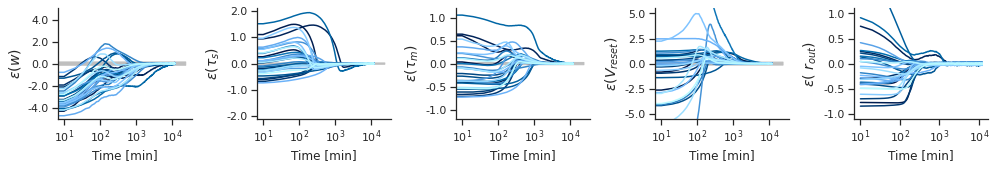

In [4]:
sns.set_palette(['#001649', '#001d50', '#002359', '#002a61', '#00316a', '#003872', '#00407a',
                 '#004783', '#004f8b', '#005694', '#005e9d', '#0066a5', '#006dae', '#0e75b7',
                 '#227cbf', '#3084c7', '#3b8bcf', '#4593d7', '#4f9adf', '#59a2e8', '#62aaf0',
                 '#6bb2f9', '#74bafe', '#7ec3ff', '#88ccff', '#91d5ff', '#9bdeff', '#a5e7ff',
                 '#aef0ff', '#b7f9ff'])

training_steps = len(data["tau_s"][0]) * 10
x = np.linspace(0., training_steps, len(data["tau_s"][0]))

fig, axs = plt.subplots(1, 5, figsize=(14, 2.5))
for i in range(data["ws"].shape[0]):
    scatter_x = data["ws"][i].shape[1] * 1.1
    axs[0].semilogx(x, dist(data["ws"][i].T, data["ws_target"][i]))
    axs[1].semilogx(x, dist(data["tau_s"][i], data["tau_s_target"][i]))
    axs[2].semilogx(x, dist(data["tau_m"][i], data["tau_m_target"][i]))
    axs[3].semilogx(x, dist(data["v_reset"][i], data["v_reset_target"][i]))
    axs[4].semilogx(x[1:], dist(lpf(data["firing_rate"][i][1:], 0.1), data["firing_rate_target"][i]))

axs[0].set_ylim([-5., 5.])
axs[1].set_ylim([-2.1, 2.1])
axs[2].set_ylim([-1.2, 1.2])
axs[3].set_ylim([-5.5, 5.5])
axs[4].set_ylim([-1.1, 1.1])

for i in [0, 3]:
    axs[i].fill_between(x * 2., 0.15, -0.15, color=[0.75, 0.75, 0.75])
for i in [1, 2]:
    axs[i].fill_between(x * 2., 0.025, -0.025, color=[0.75, 0.75, 0.75])  

axs[0].set_ylabel("$\epsilon (w)$", fontsize=fs)
axs[1].set_ylabel("$\epsilon (\\tau_s)$", fontsize=fs)
axs[2].set_ylabel("$\epsilon (\\tau_m)$", fontsize=fs)
axs[3].set_ylabel("$\epsilon (V_{reset})$ ", fontsize=fs)
axs[4].set_ylabel("$\epsilon (\ r_{out})$", fontsize=fs)

for i in range(5):
    axs[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

for i in range(5):
    sns.despine(ax=axs[i])
    axs[i].set_xlabel("Time [min]")
    axs[i].set_xticks([10., 100., 1000., 10000.])

fig.tight_layout()

fig.savefig("figure-3-a.svg", pad_inches=0.)

### Divergence from target spike times

-2ms:  0.0017813674638574042
-1ms:  0.029481267734031615
Hits:  0.9400897800000165  +/-  0.030282706017559342  SE
+1ms:  0.0214934348116572
+2ms:  0.0013905070928279099


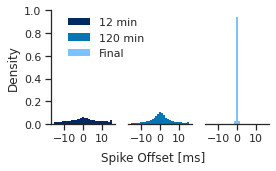

In [27]:
# Create divergence histograms
hists = {0: [], 1: [], 2: []}

for k in range(seeds_n):
    student_spike_times_1 = data["eval_0_student"][k]
    student_spike_times_2 = data["eval_1_student"][k]
    student_spike_times_3 = data["eval_100_student"][k]

    teacher_spike_times_1 = data["eval_0_teacher"][k]
    teacher_spike_times_2 = data["eval_1_teacher"][k]
    teacher_spike_times_3 = data["eval_100_teacher"][k]

    for i, (student_spike_times, teacher_spike_times) in enumerate([(student_spike_times_1, teacher_spike_times_1), (student_spike_times_2, teacher_spike_times_2), (student_spike_times_3, teacher_spike_times_3)]):
        diffs = []
        for student_spike in student_spike_times:
            nearest_teacher_spike = np.argmin(np.abs(teacher_spike_times - student_spike))
            diffs.append(student_spike - teacher_spike_times[nearest_teacher_spike])
        hist = np.histogram(diffs, density=True, bins=31, range=(-15, 16))[0]
        if np.any(np.isnan(hist)):
            continue
        hists[i].append(hist)

# Plot
colors = sns.color_palette(['#002a61', '#0675b6', '#7dc2ff'])

fig, axs = plt.subplots(1, 3, figsize=(4., 2.5))
for i in range(3):
    if i == 0:
        label = str(int(0.001*training_steps)) + " min"
    elif i == 1:
        label = str(int(.01*training_steps)) + " min"
    else:
        label = "Final"
    axs[i].bar(np.linspace(-15, 15, 31), np.mean(hists[i], axis=0), label=label, color=colors[i], linewidth=0, width=1.)
    sns.despine(ax=axs[i], left=i>0)
    if i > 0.:
        axs[i].set_yticks([])
    axs[i].set_ylim(0., 1.)
axs[0].set_ylabel("Density")
axs[0].set_xlabel(" ")
fig.text(0.55, 0.07, "Spike Offset [ms]", ha="center")
fig.legend(loc=(0.23, 0.63), frameon=False)
fig.tight_layout()

fig.savefig("figure-3-c.svg", pad_inches=0.)

print("-2ms: ", np.mean(hists[2], axis=0)[13])
print("-1ms: ", np.mean(hists[2], axis=0)[14])
print("Hits: ", np.mean(hists[2], axis=0)[15], " +/- ", np.std(np.mean(hists[2], axis=0)) / np.sqrt(seeds_n), " SE")
print("+1ms: ", np.mean(hists[2], axis=0)[16])
print("+2ms: ", np.mean(hists[2], axis=0)[17])

### Relation between firing rate and convergence time

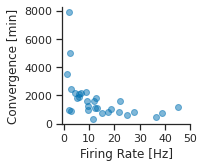

In [6]:
# Calculate convergence time
conv_times = []
for i in range(seeds_n):
    datas = [data[key][i].T for key in ["ws", "tau_s", "tau_m", "v_reset"]]
    targets = [data[key][i] for key in ["ws_target", "tau_s_target", "tau_m_target", "v_reset_target"]]
    convs = converged(datas, targets, [0.15, 0.025, 0.025, 0.15])
    
    conv_time = len(convs)
    for k, conv in enumerate(convs[::-1]):
        if conv == 1:
            conv_time -= 1
        else:
            break
    conv_times.append(conv_time * 10.)

# Plot
colors = sns.color_palette(['#0071b2'])

fig, ax = plt.subplots(figsize=(3., 2.5))
ax.scatter(data["firing_rate_target"], conv_times, color=colors[0], alpha=0.5)
ax.set_xlabel("Firing Rate [Hz]")
ax.set_ylabel("Convergence [min]")
ax.set_xticks([0., 10., 20., 30., 40., 50.])
sns.despine()
fig.tight_layout()

fig.savefig("figure-3-d.svg", pad_inches=0.)

## LRF

In [7]:
# Load data
data = dl.DataLoader("./b/results/", "adam").merge()

### Convergence of LIF parameters

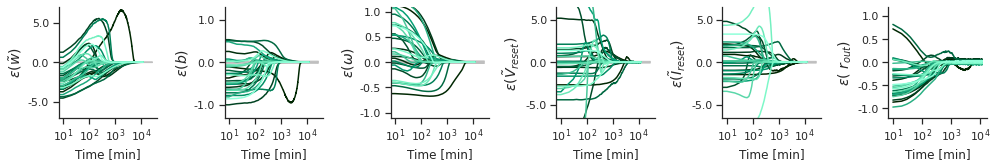

In [8]:
sns.set_palette(sns.color_palette("flare", n_colors=seeds_n))

sns.set_palette(['#002100', '#002702', '#002e0c', '#003414', '#003b1b', '#004221', '#004a27',
                 '#00512d', '#005834', '#00603a', '#006841', '#006f48', '#00774f', '#007f57',
                 '#00875e', '#008f65', '#00976d', '#049f74', '#1ba77c', '#29af83', '#34b78a',
                 '#3ebf92', '#48c799', '#51cfa1', '#5ad7a9', '#63e0b0', '#6ce8b8', '#74f0c0',
                 '#7df8c8', '#8effd8'])

training_steps = len(data["b"][0]) * 10
x = np.linspace(0., training_steps, len(data["b"][0]))

fig, axs = plt.subplots(1, 6, figsize=(14, 2.5))
for i in range(data["ws"].shape[0]):
    scatter_x = data["ws"][i].shape[1] * 1.1
    axs[0].semilogx(x, dist(data["ws"][i].T, data["ws_target"][i]))
    axs[1].semilogx(x, dist(data["b"][i], data["b_target"][i]))
    axs[2].semilogx(x, dist(data["omega"][i], data["omega_target"][i]))
    axs[3].semilogx(x, dist(data["v_reset"][i], data["v_reset_target"][i]))
    axs[4].semilogx(x, dist(data["i_reset"][i], data["i_reset_target"][i]))
    axs[5].semilogx(x[1:], dist(lpf(data["firing_rate"][i][1:], 0.1), data["firing_rate_target"][i]))

axs[0].set_ylim([-7., 7.])
axs[1].set_ylim([-1.3, 1.3])
axs[2].set_ylim([-1.1, 1.1])
axs[3].set_ylim([-6.5, 6.5])
axs[4].set_ylim([-6.5, 6.5])
axs[5].set_ylim([-1.2, 1.2])

for i in [0]:
    axs[i].fill_between(x * 2.3, 0.05, -0.05, color=[0.75, 0.75, 0.75])
for i in [1, 2]:
    axs[i].fill_between(x * 2.3, 0.025, -0.025, color=[0.75, 0.75, 0.75])  
for i in [3, 4]:
    axs[i].fill_between(x * 2.3, 0.1, -0.1, color=[0.75, 0.75, 0.75])

axs[0].set_ylabel("$\epsilon (\\tilde{w})$", fontsize=fs)
axs[1].set_ylabel("$\epsilon (b)$", fontsize=fs)
axs[2].set_ylabel("$\epsilon (\omega)$", fontsize=fs)
axs[3].set_ylabel("$\epsilon (\\tilde{V}_{reset})$ ", fontsize=fs)
axs[4].set_ylabel("$\epsilon (\\tilde{I}_{reset})$ ", fontsize=fs)
axs[5].set_ylabel("$\epsilon (\ r_{out})$", fontsize=fs)

for i in range(6):
    axs[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

for i in range(6):
    sns.despine(ax=axs[i])
    axs[i].set_xlabel("Time [min]")
    axs[i].set_xticks([10., 100., 1000., 10000.])

fig.tight_layout()

fig.savefig("figure-3-b.svg", pad_inches=0.)

### Divergence from target spike times

-2ms:  0.0009518533671402808
-1ms:  0.013865879360308994
Hits:  0.9625139255421042  +/-  0.031017089618110335  SE
+1ms:  0.018594508449352717
+2ms:  0.0009842922099325272


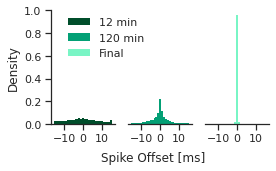

In [9]:
# Create divergence histograms
hists = {0: [], 1: [], 2: []}

for k in range(seeds_n):
    student_spike_times_1 = data["eval_0_student"][k]
    student_spike_times_2 = data["eval_1_student"][k]
    student_spike_times_3 = data["eval_100_student"][k]

    teacher_spike_times_1 = data["eval_0_teacher"][k]
    teacher_spike_times_2 = data["eval_1_teacher"][k]
    teacher_spike_times_3 = data["eval_100_teacher"][k]

    for i, (student_spike_times, teacher_spike_times) in enumerate([(student_spike_times_1, teacher_spike_times_1), (student_spike_times_2, teacher_spike_times_2), (student_spike_times_3, teacher_spike_times_3)]):
        diffs = []
        for student_spike in student_spike_times:
            nearest_teacher_spike = np.argmin(np.abs(teacher_spike_times - student_spike))
            diffs.append(student_spike - teacher_spike_times[nearest_teacher_spike])
        hist = np.histogram(diffs, density=True, bins=31, range=(-15, 16))[0]
        if np.any(np.isnan(hist)):
            continue
        hists[i].append(hist)

# Plot
colors = sns.color_palette(['#004e2b', '#03a075', '#79f5c5'])

fig, axs = plt.subplots(1, 3, figsize=(4., 2.5))
for i in range(3):
    if i == 0:
        label = str(int(0.001*training_steps)) + " min"
    elif i == 1:
        label = str(int(.01*training_steps)) + " min"
    else:
        label = "Final"
    axs[i].bar(np.linspace(-15, 15, 31), np.mean(hists[i], axis=0), label=label, color=colors[i], linewidth=0, width=1.)
    sns.despine(ax=axs[i], left=i>0)
    if i > 0.:
        axs[i].set_yticks([])
    axs[i].set_ylim(0., 1.)
axs[0].set_ylabel("Density")
axs[0].set_xlabel(" ")
fig.text(0.55, 0.07, "Spike Offset [ms]", ha="center")
fig.legend(loc=(0.23, 0.63), frameon=False)
fig.tight_layout()

fig.savefig("figure-3-e.svg", pad_inches=0.)

print("-2ms: ", np.mean(hists[2], axis=0)[13])
print("-1ms: ", np.mean(hists[2], axis=0)[14])
print("Hits: ", np.mean(hists[2], axis=0)[15], " +/- ", np.std(np.mean(hists[2], axis=0)) / np.sqrt(seeds_n), " SE")
print("+1ms: ", np.mean(hists[2], axis=0)[16])
print("+2ms: ", np.mean(hists[2], axis=0)[17])

### Relation between firing rate and convergence time

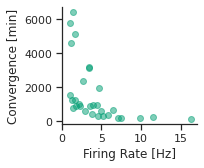

In [10]:
# Calculate convergence time
conv_times = []
for i in range(seeds_n):
    datas = [data[key][i].T for key in ["ws", "b", "omega", "v_reset", "i_reset"]]
    targets = [data[key][i] for key in ["ws_target", "b_target", "omega_target", "v_reset_target", "i_reset_target"]]
    convs = converged(datas, targets, [0.05, 0.025, 0.025, 0.1, 0.1])
    
    conv_time = len(convs)
    for k, conv in enumerate(convs[::-1]):
        if conv == 1:
            conv_time -= 1
        else:
            break
    conv_times.append(conv_time * 10.)

# Plot
colors = sns.color_palette(["#009e73"])

fig, ax = plt.subplots(figsize=(3., 2.5))
ax.scatter(data["firing_rate_target"], conv_times, color=colors[0], alpha=0.5)
ax.set_xlabel("Firing Rate [Hz]")
ax.set_ylabel("Convergence [min]")
ax.set_xticks([0., 5., 10., 15.])
sns.despine()
fig.tight_layout()

fig.savefig("figure-3-f.svg", pad_inches=0.)